In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/TUM_RGBD/freiburg2_xyz.yaml'])
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

tumrgbd
INFO: The output folder is output/TUM_RGBD/rgbd_dataset_freiburg2_xyz
INFO: The GT, generated and residual depth/color images can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_xyz/mapping_vis/
INFO: The mesh can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_xyz/mesh/
INFO: The checkpoint can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_xyz/ckpt/


tensor([[-0.1047,  0.4988, -0.8604,  0.1163],
        [-0.9935, -0.0912,  0.0680, -1.1498],
        [-0.0445,  0.8619,  0.5051,  1.4015],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [3]:
class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.first_min_area = cfg["mapping"]["first_min_area"]

        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        #self.estimate_c2w_list = slam.estimate_c2w_list
        s = np.ones((4, 4), int)
        #s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1 # Note: Adjusting elements for X-axis flip
        self.shift = 1#s  # s
        # self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        """self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            slam.H, slam.W, slam.fx, slam.fy, slam.cx, slam.cy
        )"""
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=True,
            slam=slam,
        )
        self.estimate_c2w_list = np.concatenate([p[None] for p in self.frame_reader.poses], axis=0)
        """for i in range(len(self.estimate_c2w_list)):
            self.estimate_c2w_list[i, :3,:3] = self.estimate_c2w_list[i, :3,:3].T 
            self.estimate_c2w_list[i, :3, 3] = np.matmul(-self.estimate_c2w_list[i, :3,:3], self.estimate_c2w_list[i, :3, 3])
        print(self.estimate_c2w_list.shape)"""
        print(self.estimate_c2w_list.shape)
        print(f'est list: {self.estimate_c2w_list[0]}')
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
        self.border = (
            cfg["cam"]["crop_edge"]
            if "crop_edge" in cfg["cam"]
            else cfg["Segmenter"]["border"]
        )
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]


    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        gt_color_np = np.clip(img.cpu().numpy(), 0, 1)
        plt.imshow(gt_color_np)
        plt.title(f'color {idx}')
        plt.show()
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list * self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=1000,
            border=self.border
        )
        #s[2] *= -1
        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        sns.histplot(depth.cpu().numpy().reshape(-1))
        plt.title('depth 0')
        plt.show()
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(masks,depth.cpu(), min_area=self.first_min_area)
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids, self.max_id, points_per_instance=500
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos*self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def runAuto(self, max=-1):
        visualizerForId = vis.visualizerForIds()

        print("segment first frame")
        s = self.segment_first_ForAuto()
        #print("finished segmenting first frame")
        visualizerForId.visualize(self.semantic_frames[0], path = 'test/00_after.png')
        im = visualizerForId.visualize(self.semantic_frames[0])
        plt.show()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        #s[2] *= -1
        self.samples = s
        #self.samples = np.array([[0,0,1],[0,1,0],[1,0,0], [0,0,0]])
        print(np.unique(self.samples[3], return_counts=True))
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
   
        index_frames = np.arange(
            self.every_frame_seg, self.n_img, self.every_frame_seg
        )
          
        self.plot()
        for idx in index_frames: #tqdm(index_frames, desc="Segmenting frames"):
            if idx == 200:
                #self.plot_mesh()
                return
            #print("start segmenting frame: ", idx)
            self.segment_idx_forAuto(idx)
            print(np.unique(self.samples[3], return_counts=True))
            frame = self.semantic_frames[idx // self.every_frame_seg]
            #print("finished segmenting frame: ", idx)
            #fig, ax = plt.subplots(1)

            visualizerForId.visualize(
                frame.cpu().numpy()
            )
            plt.title(f"frame: {idx}")
            #ax[1].imshow(self.frame_reader.get_colorAndDepth(idx)[1].cpu().numpy())
            plt.show()
            self.plot()
            """_,depth= frame_reader.get_colorAndDepth(idx)
            sns.heatmap(depth.cpu().numpy() == 0)
            plt.show()"""
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            _ = self.segment_idx_forAuto(self.n_img - 1)


        return self.semantic_frames, self.max_id + 1
    
    def plot_mesh(self):
        import open3d as o3d
        data = self.samples.copy()[:3].T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

        # Step 2: Compute a mesh using the Ball Pivoting algorithm
        # You may need to adjust the radii parameter based on the scale of your point cloud
        radii = [1,1,1,1]
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            pcd, o3d.utility.DoubleVector(radii))

        # Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
        mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
        o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

        plt.show()
    
    def plot(self):
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()
    
    def debugging(self):
        poses = self.estimate_c2w_list
        ff_pos = np.array([[0,1,30,300],[1,0,30,300]])
        print(ff_pos.T)
        depth = frame_reader.get_colorAndDepth(20)[1].cpu()
        ff_rw = backproject.realWorldProject(ff_pos, poses[20], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(ff_rw, poses[20], self.K)[0].T
        print(cam)
        """rw_pos = np.array([[100,0,0],[0,0,100],[0,100,0]])
        poses = self.estimate_c2w_list
        print(ff_pos)
        
        plt.imshow(depth)
        plt.show()
        ff_rw = backproject.realWorldProject(ff_pos, poses[0], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(rw_pos, poses[20], self.K)[0].T
        print(cam)
        plt.scatter(cam[:,0], cam[:,1])
        plt.show()"""

In [4]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

(3397, 4, 4)
est list: [[-0.10469234  0.49881074 -0.8603647   0.1163    ]
 [-0.9935076  -0.09118658  0.06802672 -1.1498    ]
 [-0.04452125  0.86190075  0.5051188   1.4015    ]
 [ 0.          0.          0.          1.        ]]


In [5]:
import torch
pathe = '/home/rozenberszki/project/wsnsl/output/TUM_RGBD/rgbd_dataset_freiburg2_pioneer_slam2/ckpts/00060.tar'
d = torch.load(pathe)
T_e = d['estimate_c2w_list']

In [6]:
T_e[30], segmenter.estimate_c2w_list[30]

(tensor([[ 0.8738,  0.0620,  0.4823, -2.2591],
         [ 0.4860, -0.0798, -0.8703, -2.3800],
         [-0.0154,  0.9949, -0.0999,  0.5901],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 array([[-0.07949714,  0.48712718, -0.8697053 ,  0.0826    ],
        [-0.9966915 , -0.0536491 ,  0.06105538, -1.1391    ],
        [-0.01691716,  0.87168163,  0.48978052,  1.4519    ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32))

In [7]:
segmenter.debugging()

[[  0   1]
 [  1   0]
 [ 30  30]
 [300 300]]
depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])
[[ 0.0965      0.0965      0.0965     -0.88364851]
 [-1.12989998 -1.12989998 -1.12989998 -1.0423463 ]
 [ 1.44770002  1.44770002  1.44770002  2.12124019]]
[[-5633   216]
 [-5633   216]
 [-5633   216]
 [  300   300]]


In [7]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


segment first frame
depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


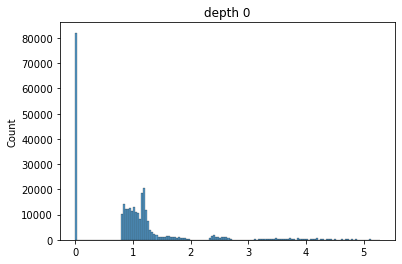

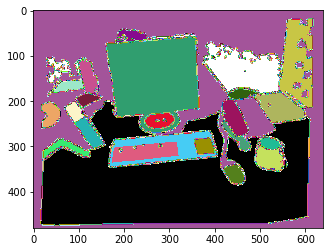

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 13., 14.,
       15., 17., 18., 19., 20., 21., 22., 23., 25., 26.]), array([3929,  595, 1274,  409,  266,  204,  190,  104,  114,   68,   85,
         84,   69,   72,   52,   56,   53,   52,   49,   45,   44,   40,
         40]))


No handles with labels found to put in legend.


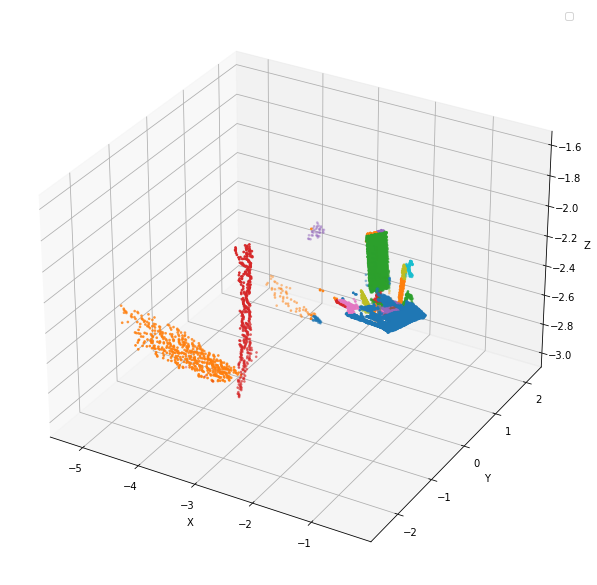

depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


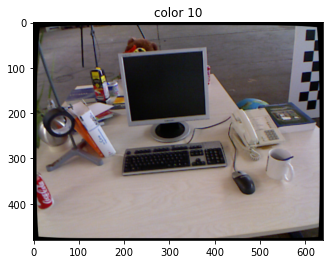

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 13., 14.,
       15., 17., 18., 19., 20., 21., 22., 23., 25., 26., 27., 28.]), array([8551, 1220, 2584,  683,  525,  405,  389,  104,  233,  113,  158,
        140,   69,  143,   52,   56,   53,   52,  168,   45,   44,   40,
         40,   87,   65]))


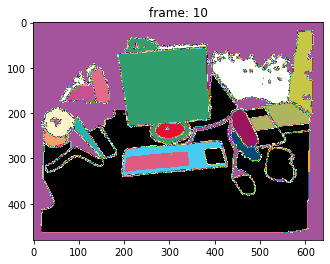

No handles with labels found to put in legend.


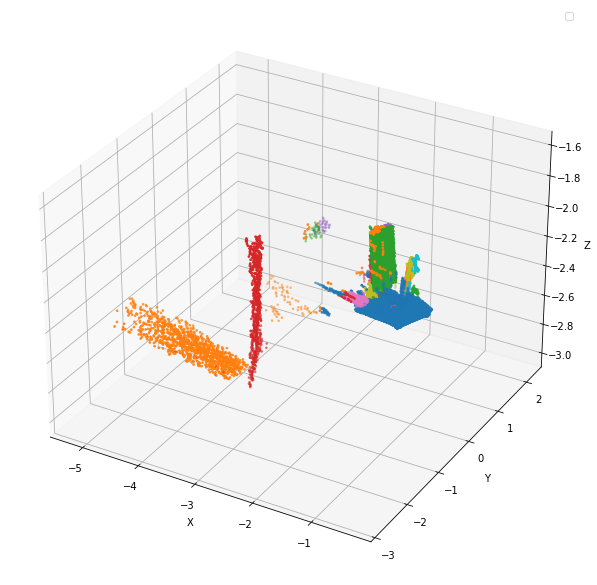

depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


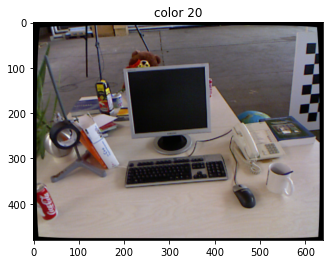

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 13., 14.,
       15., 17., 18., 19., 20., 21., 22., 23., 25., 26., 27., 28., 29.]), array([12604,  1795,  3824,   974,   525,   601,   536,   104,   346,
         113,   230,   191,    69,   143,    52,    56,    53,    52,
         264,    45,    44,    40,    40,   166,    65,    68]))


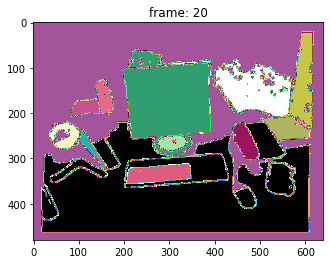

No handles with labels found to put in legend.


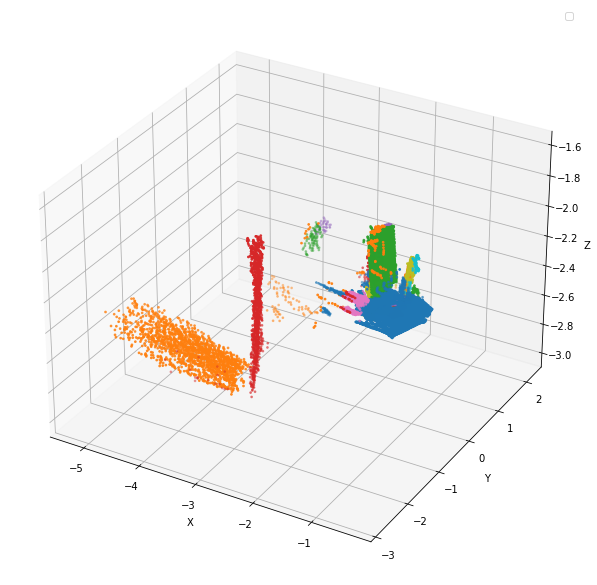

depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


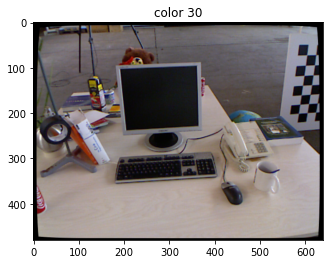

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 13., 14.,
       15., 17., 18., 19., 20., 21., 22., 23., 25., 26., 27., 28., 29.,
       30., 31.]), array([16878,  2412,  4760,  1399,   525,   791,   536,   104,   497,
         167,   385,   242,    69,   143,    52,    56,    53,    52,
         361,    45,    44,    40,    40,   166,    65,    68,    66,
          58]))


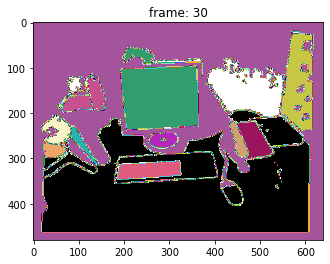

No handles with labels found to put in legend.


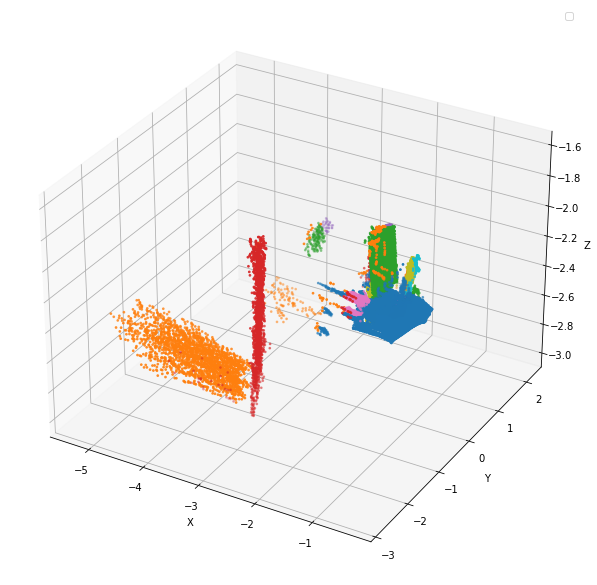

depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


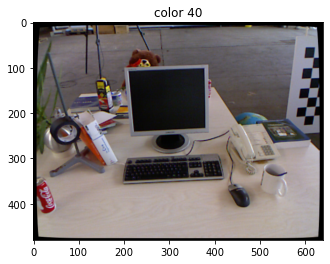

In [8]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

48

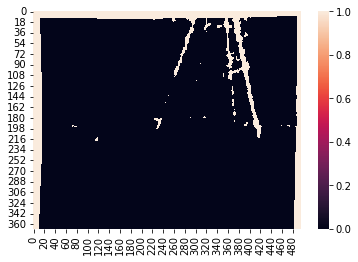

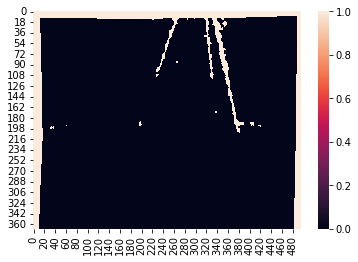

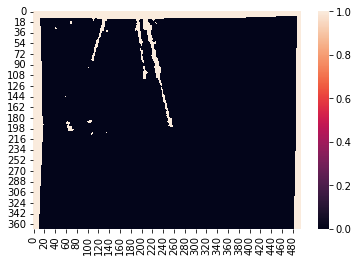

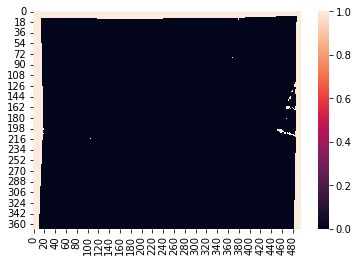

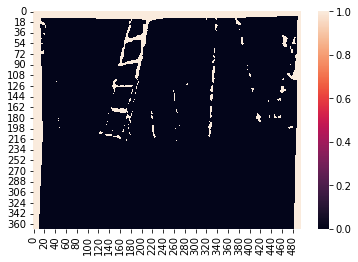

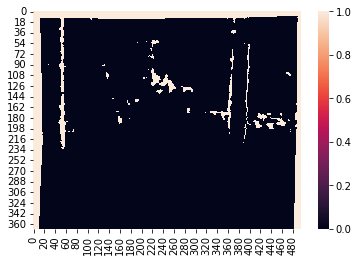

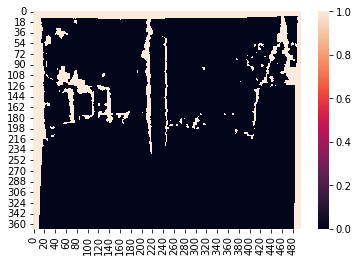

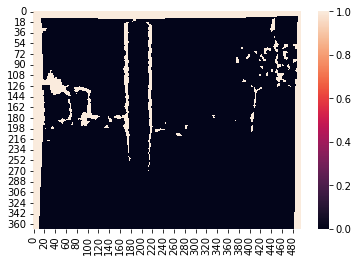

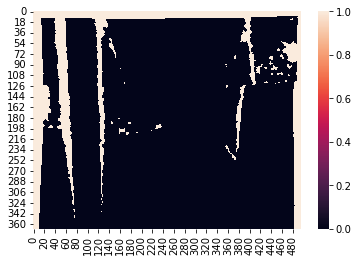

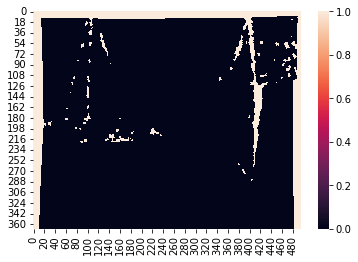

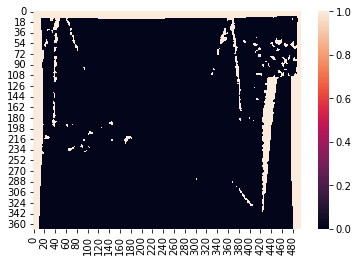

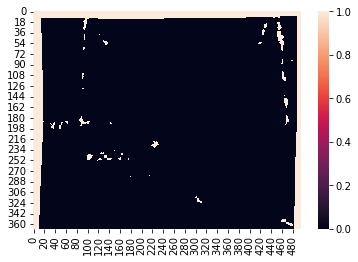

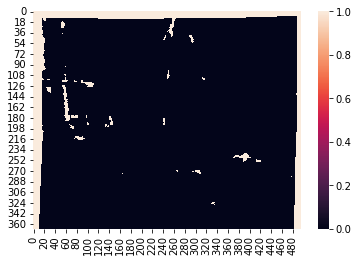

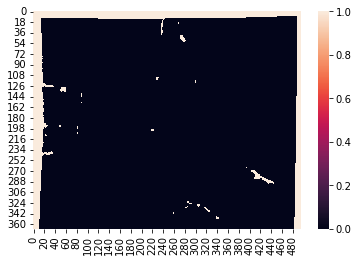

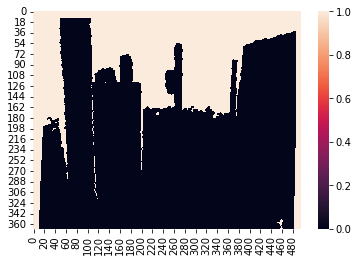

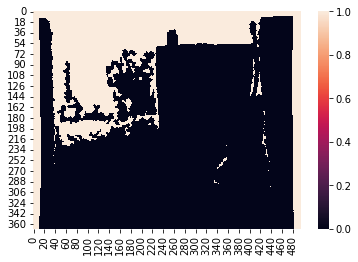

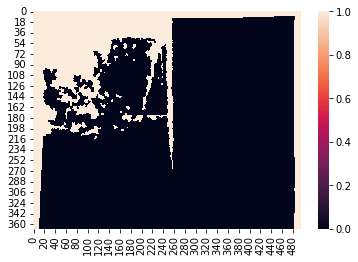

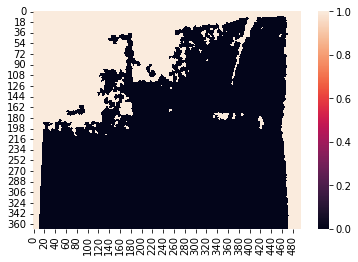

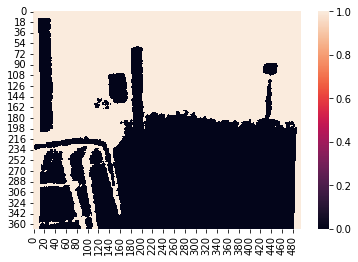

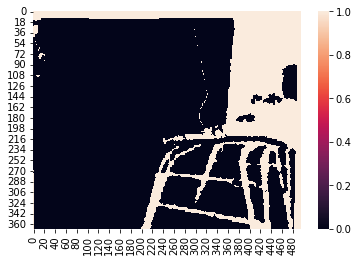

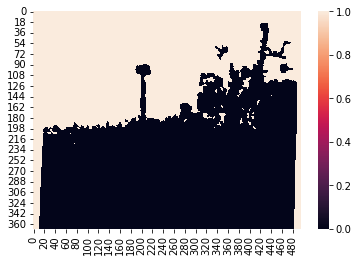

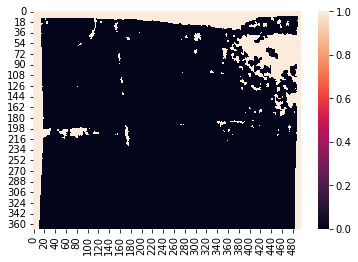

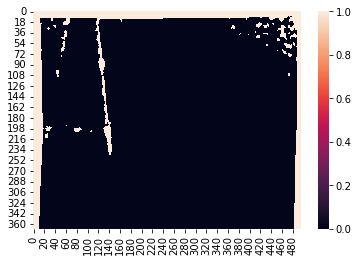

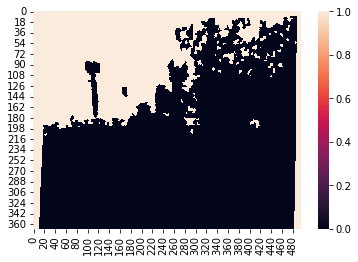

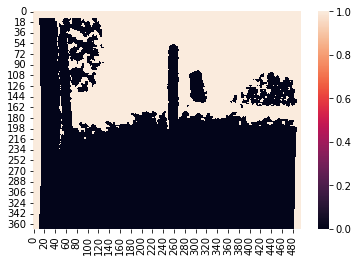

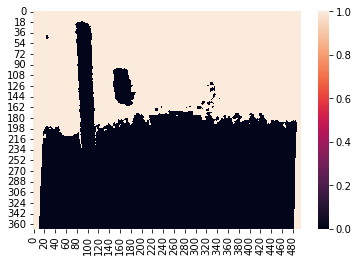

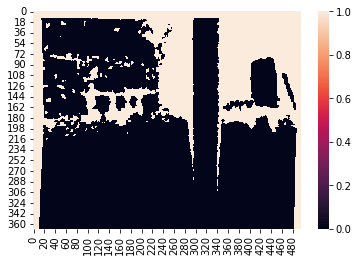

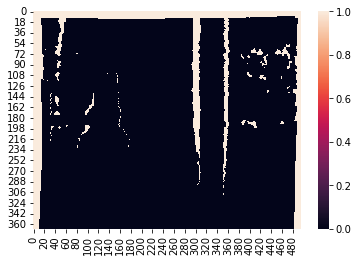

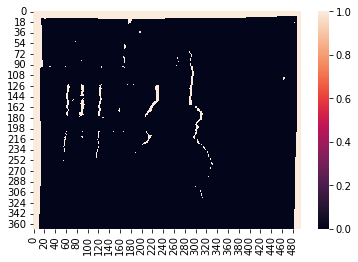

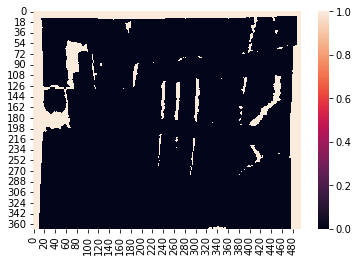

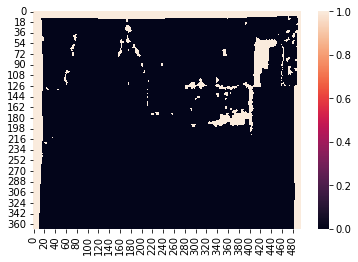

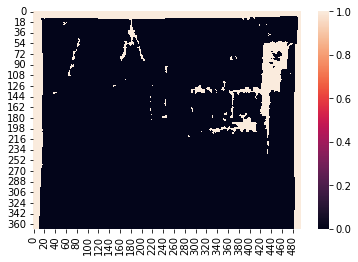

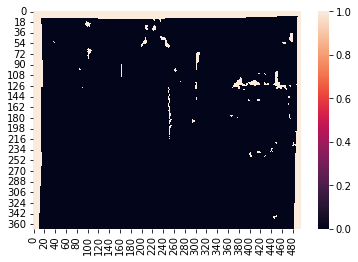

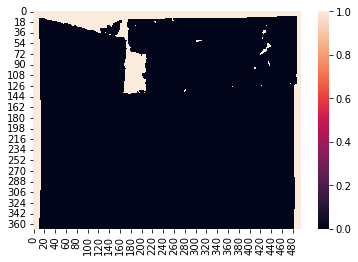

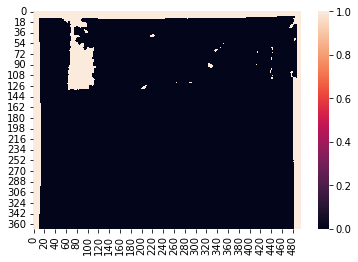

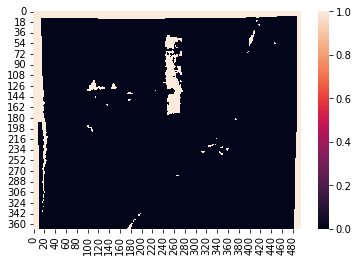

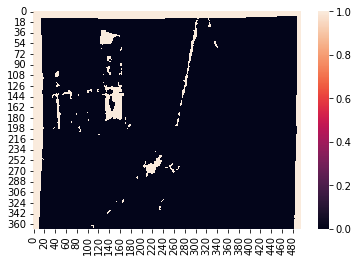

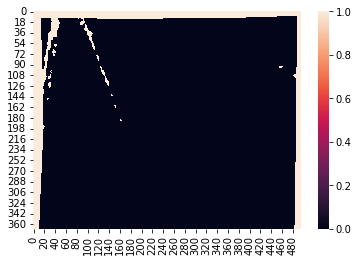

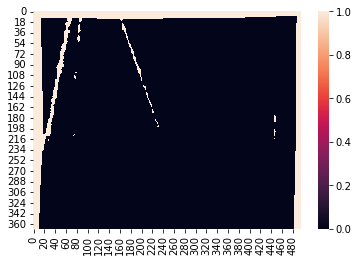

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()
